[TFL's documentation](https://tfl.gov.uk/info-for/open-data-users/our-open-data?intcmp=3671)

# Import

In [2]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
raw = pandas.read_csv('../data/tfl_raw.csv')
raw

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
5,6,Fri,LUL,Unstarted,Clapham Common,0,00:00,439,07:19,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
6,5,Thu,NR,Unstarted,Norwood Junction SR,0,00:00,454,07:34,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
7,5,Thu,NR,Unstarted,Norbury,0,00:00,955,15:55,Z0203,TKT,N,0,0,XX,LUL Travelcard-7 Day
8,5,Thu,LUL,Unstarted,Clapham Common,0,00:00,431,07:11,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
9,2,Mon,LUL,Unstarted,Kings Cross M,0,00:00,498,08:18,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


In [8]:
raw[raw['EndStation'] == 'Poplar']

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
49206,1,Sun,LUL/DLR,Canning Town,Poplar,1000,16:40,1012,16:52,-------,PPY,N,110,110,XX,PAYG
66180,2,Mon,DLR,Langdon Park,Poplar,1005,16:45,1013,16:53,-------,PPY,Y,55,45,XX,PAYG
66528,4,Wed,LUL/DLR,Shepherd's Bush Und,Poplar,1006,16:46,1043,17:23,Z0103,TKT,N,0,0,XX,LUL Travelcard-1 Month
89711,2,Mon,LUL/DLR,Tottenham Court Rd,Poplar,1013,16:53,1037,17:17,-------,PPY,N,220,220,XX,PAYG
93851,3,Tue,LUL/DLR,White City,Poplar,1014,16:54,1055,17:35,-------,PPY,N,220,220,XX,PAYG
110088,6,Fri,LUL/DLR,Caledonian Road,Poplar,1019,16:59,1052,17:32,-------,PPY,N,220,220,XX,PAYG
123613,4,Wed,LUL/DLR,Bank,Poplar,1023,17:03,1042,17:22,-------,PPY,N,220,220,XX,PAYG
130643,3,Tue,DLR,Langdon Park,Poplar,1024,17:04,1029,17:09,-------,PPY,Y,55,45,XX,PAYG
133562,4,Wed,LUL/DLR,Bank,Poplar,1025,17:05,1043,17:23,-------,PPY,N,220,220,XX,PAYG
155510,1,Sun,DLR,Lewisham DLR,Poplar,1031,17:11,1058,17:38,-------,PPY,N,110,110,XX,PAYG


# Validity

In [3]:
raw['SubSystem'].unique()

array(['LUL', 'NR', 'LUL/NR', 'LUL/NR/DLR', 'LRC', 'NR/LRC', 'LUL/NR/LRC',
       'LUL/LRC', 'DLR', 'HEX', 'LTB', 'LUL/DLR', 'TRAM', 'LUL/TRAM',
       'DLR/LRC', 'NR/DLR'], dtype=object)

In [4]:
all_times = raw['EntTimeHHMM'].unique()
all_times.sort()
all_times

array(['00:00', '01:42', '04:08', ..., '28:28', '28:29', '28:30'],
      dtype=object)

In [5]:
started_times = raw[raw['StartStn'] != 'Unstarted']['EntTimeHHMM'].unique()
started_times.sort()
started_times

array(['01:42', '04:08', '04:31', ..., '28:28', '28:29', '28:30'],
      dtype=object)

In [6]:
raw[raw['StartStn'] == 'Unstarted']['EntTimeHHMM'].value_counts()

00:00    45989
10:38        1
10:51        1
12:19        1
08:43        1
18:27        1
Name: EntTimeHHMM, dtype: int64

In [7]:
raw[raw['StartStn'] == 'Unstarted'][raw['EntTimeHHMM'] != '00:00']

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
439575,3,Tue,NR,Unstarted,Romford,1107,18:27,1145,19:05,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
1403589,3,Tue,NR,Unstarted,Romford,523,08:43,579,09:39,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
1687905,4,Wed,NR,Unstarted,Romford,638,10:38,693,11:33,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
1713955,4,Wed,NR,Unstarted,Romford,651,10:51,663,11:03,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
1901147,3,Tue,NR,Unstarted,Romford,739,12:19,746,12:26,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)


In [8]:
complete_journeys = raw[raw['SubSystem'] != 'LTB'][raw['StartStn'] != 'Unstarted'][raw['EndStation'] != 'Unfinished'][raw['EndStation'] != 'Not Applicable']

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [9]:
complete_journeys['StartStn'].append(complete_journeys['EndStation']).unique()

array(['Goodge Street', 'Preston Road', 'Holborn', 'Earls Court',
       'Victoria', 'Walthamstow Central', 'Highbury', 'Embankment',
       'Monument', 'South Kensington', "St James's Park", 'Bethnal Green',
       'Tower Hill', 'St Pauls', 'High Barnet', 'All Saints', 'Leyton',
       'Kings Cross M', 'Manor House', 'Woolwich Arsenal DLR',
       'Putney Bridge', 'Kings Cross T', 'Southfields', 'Vauxhall',
       'Golders Green', 'Oxford Circus', 'Fulham Broadway',
       'Shadwell DLR', 'Bond Street', 'Camden Town', 'Piccadilly Circus',
       'Maida Vale', 'Clapham South', 'Hammersmith D', 'Gloucester Road',
       'East Finchley', 'Great Portland St', 'Charing Cross',
       'Finchley Road', 'Notting Hill Gate', 'Waterloo JLE',
       'Euston Square', 'Edgware Road M', 'Chancery Lane', 'Wimbledon',
       'Baker Street', 'Ealing Broadway', 'Euston', 'Victoria TOCs',
       'Covent Garden', 'Sloane Square', 'London Bridge',
       'Hyde Park Corner', 'Paddington', 'Knightsbridge', 

# By hour

In [10]:
complete_journeys['EntTimeHHMM']=complete_journeys['EntTimeHHMM'].str.slice(0,2)

## By start and end

In [11]:
start_end_by_hour = complete_journeys.groupby(('EntTimeHHMM', 'StartStn', 'EndStation','daytype')).size()

In [12]:
start_end_by_hour.sort_values()

EntTimeHHMM  StartStn            EndStation          daytype
04           Baker Street        Euston Square       Fri         1
16           Tottenham Court Rd  Swiss Cottage       Fri         1
                                 Stockwell           Tue         1
                                                     Sat         1
                                                     Fri         1
                                 Stepney Green       Mon         1
                                 Stanmore            Tue         1
                                 Stamford Brook      Sun         1
                                 St Pauls            Sun         1
                                                     Sat         1
                                 St James Street     Sat         1
                                 Southwark           Thu         1
                                 Tooting Bec         Fri         1
                                 Southgate           Tue         1
 

### Checking

In [13]:
start_end_by_hour.sum()

765324

In [14]:
complete_journeys.shape[0]

765324

# By days

In [15]:
by_day_time = complete_journeys.groupby(('EntTimeHHMM', 'daytype')).size()
by_day_time = by_day_time.reset_index()
by_day_time.columns = ['time', 'day', 'journeys']
by_day_time['time'] = pandas.to_numeric(by_day_time['time'])
by_day_time.head()

,time,day,journeys
0,04,Fri,13
1,04,Mon,7
2,04,Sat,9
3,04,Thu,11
4,04,Tue,9


';'

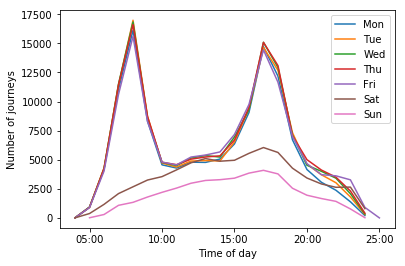

In [130]:
ax = plt.subplot(xlabel='Time of day', ylabel='Number of journeys',)
for day in ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'):
    dat = by_day_time[by_day_time['day']==day]
    dat.plot(x='time', y='journeys', ax=ax, label=day)

ax.set_xlabel('Time of day')
ax.set_xticklabels(['{:0>2}:00'.format(int(x)) for x in ax.get_xticks()])